# **DT-BASE Tutorial**

This is a tutorial on how to use the `dtbase` package to develop and quantify the **`DT-BASE`** causal model in Python. For more information on the DT-BASE causal model, please see [this](sciencedirect.com/science/article/abs/pii/S095183201830053X#:~:text=The%20role%20of%20the%20Data,links%20in%20the%20SoTeRiA%20framework.) paper.

The tutorial expects an understanding of the **`DT-BASE`** model, basic Python syntax, and a working installation of the `dtbase` package.

### **Objective** : 
Quantify the model on a subset of [this](https://databank.illinois.edu/datasets/IDB-6772942) dataset for an example Training Causal Model. The desired output is a conditional probability table for a given node, as well as the causal model structure which can then be integrated with the DT-SITE module using a Bayesian Belief Network (BBN).

First, import the `dtbase` package.

In [1]:
import dtbase as db

Create a `DTBase` instance, which stores the causal model structure. Optionally, provide the `file_path` argument which saves the database file to a given file path. If not file path is provided, an in-memory database is used.

In [2]:
model = db.DTBase('tutorial_data/model.db')

The `DTBase` model is essentially made up of four major components:
- `db.Node` : represents a node in the model.
- `db.Estimate` : represents an estimate of `m1`, `m2`, or `m3` with associated uncertainty using a range.
- `db.Reference` : stores a theoretical reference which supports the claim of a causal link between two nodes.
- `db.Link` : represents a causal link between two nodes in the model.

### **`Node`** : 
A `Node` has the following important attributes:
- `node_id` (str) : a unique id representing the `Node` in the model.
- `name` (str) : the name of the `Node`.
- `keywords` (str) : an optional sequence of space separated keywords describing the Node.

A `Node` can be constructed using the `db.Node()` constructor, and added to the model with the `DTBaseModel.add_node()` function.

In [3]:
# add the 'Conditions & Standards for Task Performance' node to the model.
model.add_node(db.Node(node_id='cstp',
                       name='Conditions & Standards for Task Performance'))

# add the 'Job/Task Analysis' node to the model.
model.add_node(db.Node(node_id='jta',
                       name='Job/Task Analysis'))

# add the 'Organization Learning Objectives' node to the model.
model.add_node(db.Node(node_id='olo',
                       name='Organizational Learning Objectives'))

It is possible to view the `set` of all `node_id`s of Nodes in the model using the `DTBase.nodes()` function.

In [4]:
model.nodes()

{'cstp', 'jta', 'olo'}

### **`Estimate`** : 
Given the nature of the analyst estimates for `m1`, `m2` and `m3`, there is naturally some uncertainty in those estimates. The `Estimate` object allows the analyst to capture this uncertainty, using an upper and lower bound. 
An `Estimate` has the following important attributes:
- `estimate_type` (db.EstimateTypes) : An EstimateTypes enum value representing the type of uncertainty estimate that is provided. At the moment, two kinds of uncertainty estimates are supported (in later releases, more options will be provided):
    - `EstimateTypes.UNIFORM` : a and b are the min and max parameters of a uniform distribution.
    - `EstimateTypes.NORMAL` : a and b are the upper and lower bounds of a 95% confidence interval.
- `a` (float) : the lower bound parameter for the estimate.
- `b` (float) : the upper bound parameter for the estimate.
An `Estimate` can be constructed using the `db.Estimate()` constructor.

In [5]:
# create an Estimate representing a 95% confidence interval of (.9, 1)
example_m1 = db.Estimate(estimate_type=db.EstimateTypes.NORMAL,
                         a=.9, 
                         b=1.0)

### **`Reference`** : 
A `Reference` stores the metadata of a reference used to support a claim of a causal link.
- `ref_id` (str) : the unique id of the `Reference` object.
- `title` (str) : the title of the `Reference`.
- `authors` (str) : the authors of the `Reference` as a space-separated `str`.
- `year` (str) : the year in which the `Reference` was published.
- `publication_type` (str) : the type of the publication. Must be a valid .ris `TY` tag.
- `publisher` : the publisher of the `Reference`.


A `Reference` can be constructed using the `db.Reference()` constructor, or using a `risparser`.

In [6]:
# create a Reference object for the original DT-Base paper
hpm1 = db.Reference(ref_id='hpm1',
                    title='Human Performance Management: Personnel Training REGDOC-2.2.2',
                    authors='Canadian Nuclear Safety Commission',
                    year='2013',
                    publication_type='GOVDOC',
                    publisher='Canadian Nuclear Safety Commission')

### **`Link`** : 
A `Link` defines a causal relationship between two `Node`s supported by evidence. A `Link` has the following important attributes:
- `link_id` (str) : a unique id representing the `Link` in the model.
- `parent_id` (str) : the `node_id` of the child `Parent` in the `Link`.
- `child_id` (str) : the `node_id` of the child `Node` in the `Link`.
- `m1` (db.Estimate) : an `Estimate` for the m1 parameter.
- `m2` (db.Estimate) : an `Estimate` for the m2 parameter.
- `m3` (db.Estimate) : an `Estimate` for the m1 parameter.
- `m1_memo` (str) : an optional justification of the `m1` estimate.
- `m2_memo` (str) : an optional justification of the `m2` estimate.
- `m3_memo` (str) : an optional justification of the `m3` estimate.
- `ref_id` (str) : the id of the `Reference` object which stores the reference supporting the claim of a causal link.

A `Link` can be constructed using the `db.Link()` constructor, and added to the model with the `DTBaseModel.add_link()` function.

In [7]:
# add a causal link from node 'cstp' to node 'olo'
model.add_link(db.Link(link_id='cstpolo1',
                    parent_id='cstp',
                    child_id='olo',
                    m1=db.Estimate(db.EstimateTypes.UNIFORM, .90, .99),
                    m2=db.Estimate(db.EstimateTypes.NORMAL, .10, .95),
                    m3=db.Estimate(db.EstimateTypes.UNIFORM, .50, .99),
                    m1_memo='Regulatory document very likely credible',
                    m2_memo='The definition is conditional on OJT, therefore the weight of influence for the generic definition is medium likelihood',
                    m3_memo='I am likely confident with this concept',
                    ref_id='hpm1')) # use the Reference we created earlier

### **Importing Nodes and Links** : 
For some users, it may be easier to use a spreadsheet for the data entry. For this purpose, it is possible to import a list of `Node`s and/or `References` and/or `Link`s as a `.csv` file.
This `.csv` file can be obtained by calling `export_model` on a `DTBaseModel` or can be created from scratch. In this example, we populate the full Training Causal model by import `.csv` spreadsheets of data.

In [8]:
# Start with an empty model.
training_model = db.DTBase('tutorial_data/training.db')

**Nodes:**
To import a .csv file of `Node`s, each `Node` must be represented on one line with the following format:

`<node_id>, <name>, <keywords>`.

In [9]:
import pandas as pd

In [10]:
# Example of part of a correctly formatted nodes.csv file
pd.read_csv('tutorial_data/nodes.csv', header=None).head()

,0,1,2
0,cstp,Conditions & Standards for Task Performance,Conditions & Standards for Task Performance
1,con,Content,Content
2,ipt,Inst. Preparation/Time,Inst. Preparation/Time
3,it,Inst. Training,Inst. Training
4,ik,Inst.Knowledge,Inst.Knowledge


In [11]:
# import a list of nodes from nodes.csv into the model.
training_model.import_nodes('tutorial_data/nodes.csv')

**References**: To import a .csv file of `Reference`s, each `Reference` must be represented on one line with the following format:

`<ref_id>, <title>, <authors>, <year>, <publication_type>, <publication_year>`.

In [12]:
# Example of part of a correctly formatted refs.csv file
pd.read_csv('tutorial_data/refs.csv', header=None).head()

,0,1,2,3,4,5
0,b1,Instructor excellence: Mastering the delivery ...,"Powers, Bob, Rothwell, William",2007,Book,Wiley
1,b2,Simulation fidelity in training system design:...,"Hays, Robert T, Singer, Michael J",2012,Book,Springer
2,b3,Training complex cognitive skills: A four-comp...,"Van Merrianboer, Jeroen JG",1997,Book,Technology and Engineering
3,b4,"Training in organizations: Needs assessment, d...","Goldstein, Irwin L,Ford, J Kevin",2002,Book,Wadsworth Thompson Learning
4,gd1,Development of instructors for nuclear power p...,IAEA,2004,Government Document,International Atomic Energy Agency


In [13]:
# import a list of references from refs.csv into the model.
training_model.import_refs('tutorial_data/refs.csv')

**Links**: To import a .csv file of `Link`s, each `Link` must be represented on one line with the following format:

`<link_id>, <parent_id>, <child_id>, <m1_estimate_type>, <m1_lower>, <m1_upper>, <m2_estimate_type>, <m2_lower>, <m2_upper>, <m3_estimate_type>, <m3_lower>, <m3_upper>, <m1_memo>, <m2_memo>, <m3_memo>, <ref_id>`.

In [14]:
# Example of part of a correctly formatted links.csv file
pd.read_csv('tutorial_data/links.csv', header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,l79,tp,ti,UNIFORM,0.900,0.990,UNIFORM,0.6,0.96,UNIFORM,0.6,0.96,journal publication very likely this reference...,this evidence provides support for a virtually...,I am likely confident with this concept,j24
1,l80,tp,ti,UNIFORM,0.900,0.990,UNIFORM,0.6,0.96,UNIFORM,0.6,0.96,governmental report is very likely credible,this evidence provides support for a likely re...,I am likely confident with this concept,gr12
2,l78,tp,ti,UNIFORM,0.900,0.990,UNIFORM,0.6,0.96,UNIFORM,0.6,0.96,Regulatory document very likely credible,this evidence provides support for a likely re...,I am likely confident with this concept,gr12
3,l76,tna,pd,UNIFORM,0.991,0.999,UNIFORM,0.6,0.96,UNIFORM,0.6,0.96,Very high journal impact factor virtually cert...,most important step indicates virtually certai...,I am likely confident with this concept,gr9
4,l75,tna,pd,UNIFORM,0.900,0.990,UNIFORM,0.6,0.96,UNIFORM,0.6,0.96,journal publication very likely this reference...,the concept is definitional and supported by m...,I am likely confident with this concept,gr9


In [15]:
# import a list of links from links.csv into the model. Make sure to import References and Nodes first!!!
training_model.import_links('tutorial_data/links.csv')

### **Quantification**

The DT-BASE module is designed to output the conditional probability table for a particular `Node`, as well as a visual representation of the model.

To view a visual representation of the model, use the `draw` function of the `DTBase` class.

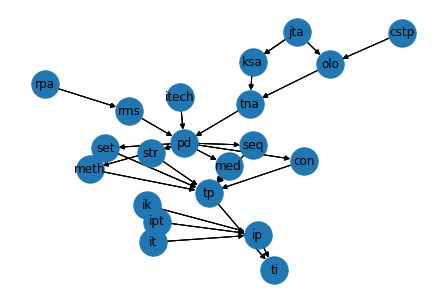

In [16]:
training_model.draw()

To calculate the conditional probability table, run the `calculate()` function, supplying a `DTBase` model object, a `target_node` str with the `node_id` of the target node, and a `db.AggregationMethod` enum value.

In [24]:
# calculate the conditional probability table for the 'olo' node.
db.calculate(training_model, 'olo', db.AggregationMethod.ARITHMETIC)

{'jta': array([0., 0., 0., ..., 0., 0., 0.]), 'cstp': array([0., 0., 0., ..., 0., 0., 0.])}


defaultdict(<function dtbase.quantify.calculate.<locals>.<lambda>()>,
            {('cstp',): (0.7854372998986945, 0.11618558637168486),
             ('jta',): (0.7826157055155208, 0.09017368012922604),
             ('cstp', 'jta'): (0.9533648019663813, 0.03358622026423544)})

### **Exporting Data**

A `DTBase` model is saved to the file given when creating the model. Loading this file will reload the entire model. It is also possible to export the module to a `.zip` file. This can be accomplished with the `export_model()` function.

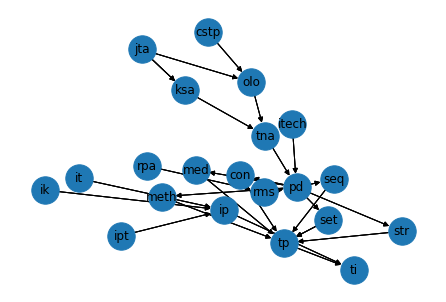

In [27]:
# export the model data.
training_model.export_model('tutorial_data/training_causal_model')